# Imports

In [ ]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import datetime
%matplotlib notebook
%matplotlib inline

#### Exploratory Data Analysis ####
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords,wordnet 
from wordcloud import WordCloud
from textblob import TextBlob

nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

# Main Google Play Store Dataset

## Reading in Google Play Store Data

Dataset source: https://www.kaggle.com/gauthamp10/google-playstore-apps

In [ ]:
# Code to mount Google Drive for reading CSV
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# read the above CSV into Python using pandas
# Make sure that Google Drive is mounted so you can read directly from Project folder
# The below line will likely need to change depending on your file path
playstore = pd.read_csv('/content/drive/MyDrive/BSAN 6080 Project/Datasets/Final_Main_Google_Playstore_Dataset.csv')

## EDA

### Cleaning (Only need to run if using old dataset)

In [ ]:
# replace values that have unneeded characters
playstore.replace(r'Varies with device',np.nan,regex=True,inplace=True)
playstore.replace(r'',np.nan,regex=True,inplace=True)
playstore.head(2)

,Unnamed: 0,App Name,App Id,Category,Rating,Rating Count,Installs,Minimum Installs,Maximum Installs,Free,...,Minimum Android,Developer Id,Released,Last Updated,Content Rating,Ad Supported,In App Purchases,Editors Choice,update_date,Estimated_Installs
0,0,foodpanda - Local Food & Grocery Delivery,com.global.foodpanda.android,Food & Drink,4.4,1258493.0,"10,000,000+",10000000.0,48828081,True,...,4.3 and up,Foodpanda GmbH a subsidiary of Delivery Hero SE,"Nov 19, 2013",1594061045000,Everyone,False,False,False,2020-07-06 18:44:05,1.144728e+07
1,1,"Tripadvisor Hotel, Flight & Restaurant Bookings",com.tripadvisor.tripadvisor,Travel & Local,4.4,1360172.0,"100,000,000+",100000000.0,371284181,True,...,NaN,Tripadvisor,"Jul 12, 2010",1593700848000,Everyone,True,False,False,2020-07-02 14:40:48,1.101118e+08


In [ ]:
# explore the datatypes of the columns
playstore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435319 entries, 0 to 435318
Data columns (total 23 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Unnamed: 0          435319 non-null  int64  
 1   App Name            435318 non-null  object 
 2   App Id              435319 non-null  object 
 3   Category            435319 non-null  object 
 4   Rating              435319 non-null  float64
 5   Rating Count        435319 non-null  float64
 6   Installs            435319 non-null  object 
 7   Minimum Installs    435319 non-null  float64
 8   Maximum Installs    435319 non-null  int64  
 9   Free                435319 non-null  bool   
 10  Price               435319 non-null  float64
 11  Currency            435316 non-null  object 
 12  Size                415421 non-null  object 
 13  Minimum Android     423047 non-null  object 
 14  Developer Id        435317 non-null  object 
 15  Released            418281 non-nul

In [ ]:
# Remove any unnecessary columns from dataframe
playstore.drop(columns=['Developer Email','Privacy Policy','Developer Website'],inplace=True)
playstore.head(2)

KeyError: ignored

In [ ]:
#Create new column for the datetime format of "last updated"
playstore['update_date']=playstore['Last Updated'].apply(lambda d: datetime.datetime.fromtimestamp(int(d)/1000).strftime('%Y-%m-%d %H:%M:%S'))
#confirm format
print(playstore['update_date'])
playstore.head(2)

In [ ]:
#identifying null values 
playstore.isnull().sum()

In [ ]:
#creating preliminary estimate of installs variable  

#playstore['Average_Installs'] = (playstore['Minimum Installs'] + playstore['Maximum Installs'])/2

In [ ]:
#creating an interpolated random value given the Min and Max Installs
#allows for more wholistic view of an installs estimation
playstore['Estimated_Installs'] = ((playstore['Minimum Installs'])+(np.random.rand()*
                                (playstore['Maximum Installs'] - playstore['Minimum Installs'])))

In [ ]:
#ensuring Average_Installs was created 
playstore.head(2)

In [ ]:
#Replacing NaN values under Rating & Rating Count columns with 0 to identify apps without Ratings.\
#Almost anyone can create an app and upload it to the app store. The lowest rating an app can receive is 1 out 5. 
#We drop the rows with a rating of 0 or rating count of 0 to be able to better evaluate apps that are actually used & rated within the Google Play Store

playstore_sample_replace = {'Rating':{np.nan:0},
              'Rating Count':{np.nan:0}}
playstore = playstore.replace(playstore_sample_replace)

playstore.drop(playstore[playstore['Rating Count']==0].index, inplace=True)
playstore.drop(playstore[playstore['Rating']==0].index, inplace=True)

### Export Clean Data

In [ ]:
playstore.to_csv('Final_Main_Google_Playstore_Dataset.csv')

### Visualizations and Analysis

#### Question 1: Are there more installs/high rating for...

In [ ]:
# playstore df for free apps only
free_apps = playstore.loc[playstore['Price']==0]

# playstore df for free apps with in app purchases only 
free_apps_with_in_app_purchase = free_apps.loc[free_apps['In App Purchases']==True]

# playstore df for to paid apps only
paid_apps = playstore.loc[playstore['Price']!=0]

In [ ]:
comparison = {'Overall': [playstore.Rating.mean(),playstore['Estimated_Installs'].mean()],
        'Free Apps': [free_apps.Rating.mean(),free_apps['Estimated_Installs'].mean()],
        'Free Apps w/ In-App Purchases' : [free_apps_with_in_app_purchase.Rating.mean(),free_apps_with_in_app_purchase['Estimated_Installs'].mean()],
        'Paid Apps' : [paid_apps.Rating.mean(),paid_apps['Estimated_Installs'].mean()]
        }

comparison_table = pd.DataFrame(comparison, index=['Average Ratings','Average Installs'])

# add 'Best Score' column
comparison_table['Highest Average'] = comparison_table.idxmax(axis=1)

comparison_table

,Overall,Free Apps,Free Apps w/ In-App Purchases,Paid Apps,Highest Average
Average Ratings,4.123768,4.119784,4.125750e+00,4.205086,Paid Apps
Average Installs,710167.305775,744097.846061,1.745109e+06,17626.821739,Free Apps w/ In-App Purchases


#### Question 2: Are you more likely to install a certain category of apps?

In [ ]:
#Average installs per Category 
playstore.pivot_table(values='Estimated_Installs',index='Category',columns=None,aggfunc='mean').sort_values('Estimated_Installs', ascending=False).round(2)

,Estimated_Installs
Category,
Video Players & Editors,4443759.20
Communication,4000036.70
Racing,3819435.17
Action,3078721.22
Music,2097993.18
Arcade,2096029.31
Social,1928851.06
Productivity,1792525.56
Casual,1752159.05


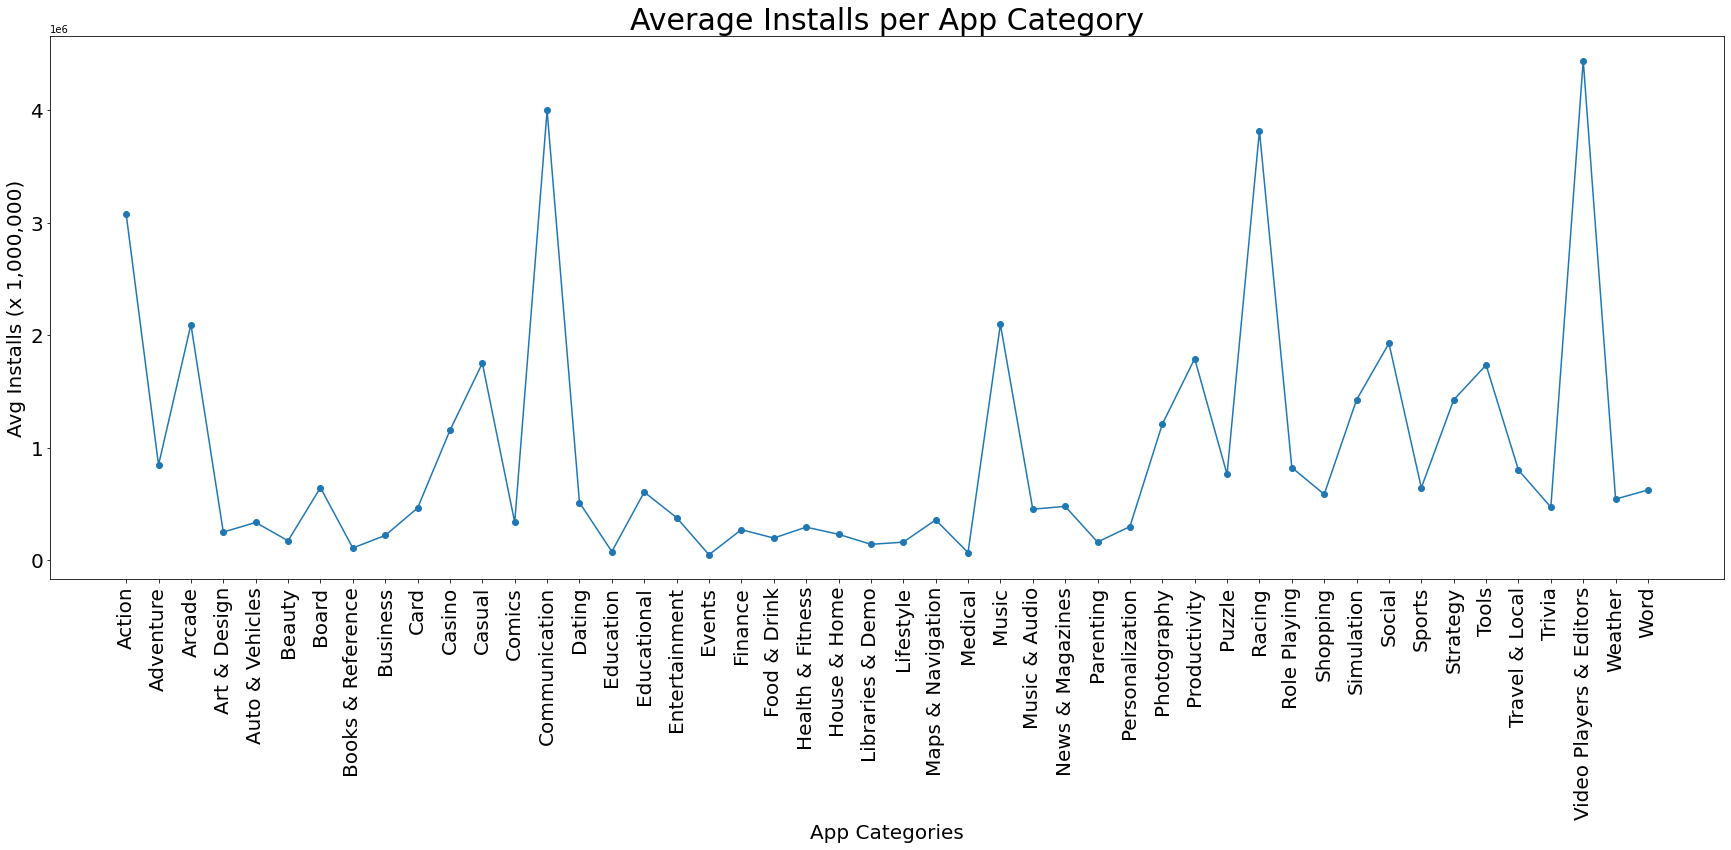

In [ ]:
#Average installs per app category
cattable = playstore.pivot_table(values='Estimated_Installs',index='Category',columns=None,aggfunc='mean')

plt.figure(figsize= (30,10))
plt.plot(cattable.index, cattable['Estimated_Installs'], marker='o')
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.title('Average Installs per App Category', fontsize=30)
plt.ylabel('Avg Installs (x 1,000,000)', fontsize=20)
plt.xlabel('App Categories', fontsize=20)
plt.show()

#### Question 3: Are you likely to pay more for a certain category of apps?

In [ ]:
# average price per app category 
playstore.pivot_table(values='Price',index='Category',columns=None,aggfunc='mean').sort_values('Price', ascending=False)

,Price
Category,
Adventure,0.927018
Medical,0.761518
Role Playing,0.712629
Strategy,0.573896
Maps & Navigation,0.568672
Sports,0.424793
Weather,0.423707
Board,0.401110
Auto & Vehicles,0.377638


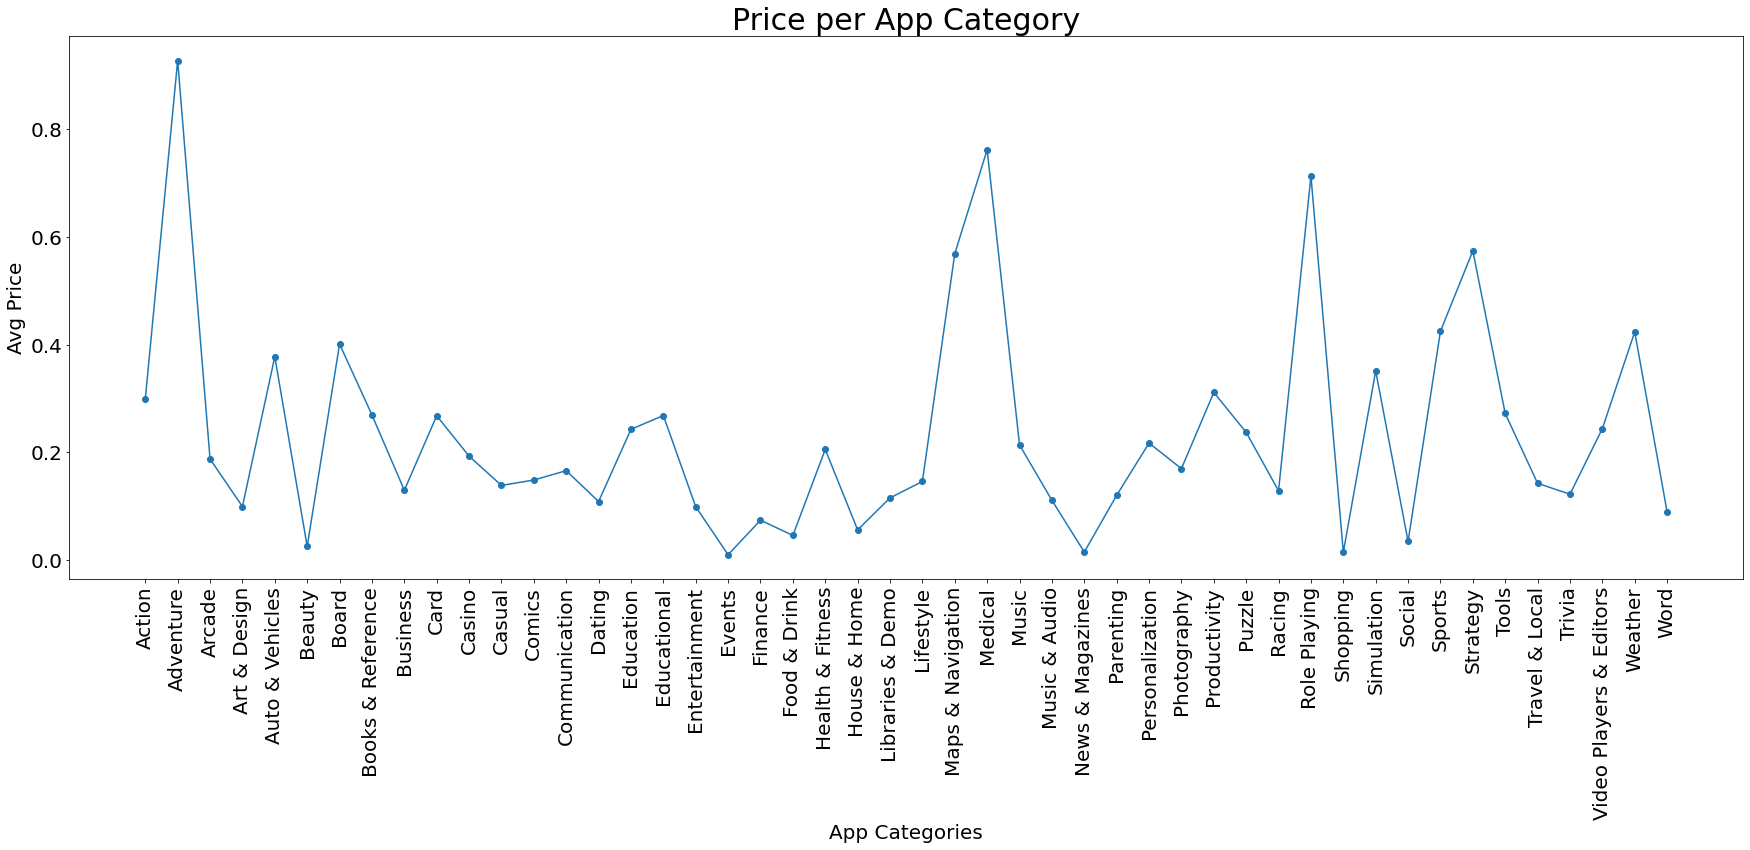

In [ ]:
# average price of an app based on app category 
cattable = playstore.pivot_table(values='Price',index='Category',columns=None,aggfunc='mean')

plt.figure(figsize= (30,10))
plt.plot(cattable.index, cattable['Price'], marker='o')
plt.xticks(rotation=90, fontsize=20)
plt.yticks(fontsize=20)
plt.title('Price per App Category', fontsize=30)
plt.ylabel('Avg Price', fontsize=20)
plt.xlabel('App Categories', fontsize=20)
plt.show()

#### Question 4: Are there more apps that are ad supported vs not ad supported?

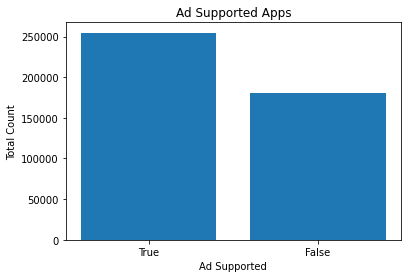

True     254712
False    180607
Name: Ad Supported, dtype: int64

In [ ]:
# apps with ads vs no-ads
plt.bar(['True','False'], playstore['Ad Supported'].value_counts())
plt.xlabel('Ad Supported')
plt.ylabel('Total Count')
plt.title('Ad Supported Apps')
plt.show() 

playstore['Ad Supported'].value_counts()

Is this also true for Communication apps (as discussed above)?

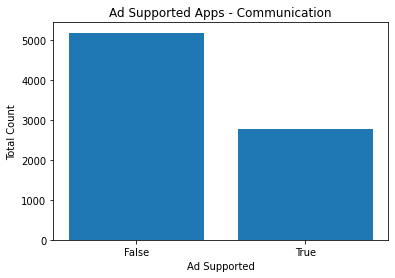

False    5187
True     2777
Name: Ad Supported, dtype: int64

In [ ]:
# slice for only category = Communication
comm_apps = playstore.loc[playstore['Category']=='Communication']
comm_apps

#apps with ads vs no-ads - Communication 
plt.bar(['False','True'], comm_apps['Ad Supported'].value_counts())
plt.xlabel('Ad Supported')
plt.ylabel('Total Count')
plt.title('Ad Supported Apps - Communication')
plt.show() 

comm_apps['Ad Supported'].value_counts()

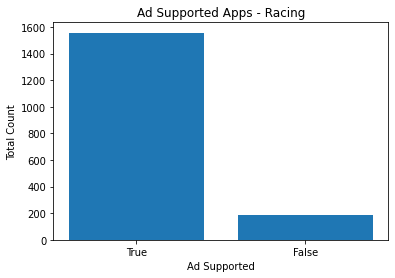

True     1557
False     188
Name: Ad Supported, dtype: int64

In [ ]:
# slice for only category = Racing
comm_apps = playstore.loc[playstore['Category']=='Racing']
comm_apps

#apps with ads vs no-ads - Racing 
plt.bar(['True','False'], comm_apps['Ad Supported'].value_counts())
plt.xlabel('Ad Supported')
plt.ylabel('Total Count')
plt.title('Ad Supported Apps - Racing')
plt.show() 

comm_apps['Ad Supported'].value_counts()

#### Question 5: Are there more apps that have in app purchases vs no in app purchases?

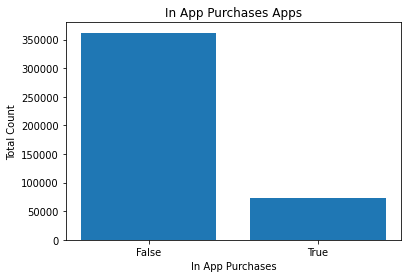

False    361955
True      73364
Name: In App Purchases, dtype: int64

In [ ]:
# apps with in-app purchases vs no -in-app purchases. 
plt.bar(['False','True'], playstore['In App Purchases'].value_counts())
plt.xlabel('In App Purchases')
plt.ylabel('Total Count')
plt.title('In App Purchases Apps')
plt.show() 

playstore['In App Purchases'].value_counts()

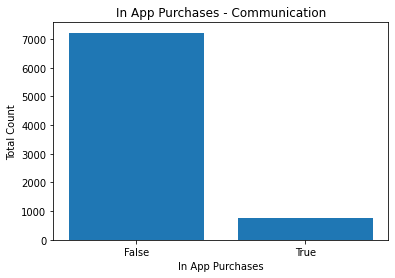

False    7220
True      744
Name: In App Purchases, dtype: int64

In [ ]:
# slice for only category = Communication
comm_apps = playstore.loc[playstore['Category']=='Communication']
comm_apps

# apps with in app purchases vs no in app purchases - Communication 
plt.bar(['False','True'], comm_apps['In App Purchases'].value_counts())
plt.xlabel('In App Purchases')
plt.ylabel('Total Count')
plt.title('In App Purchases - Communication')
plt.show() 

comm_apps['In App Purchases'].value_counts()

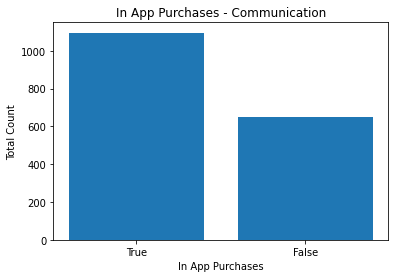

True     1095
False     650
Name: In App Purchases, dtype: int64

In [ ]:
# slice for only category = Racing
comm_apps = playstore.loc[playstore['Category']=='Racing']
comm_apps

# apps with in app purchases vs no in app purchases - Racing 
plt.bar(['True','False'], comm_apps['In App Purchases'].value_counts())
plt.xlabel('In App Purchases')
plt.ylabel('Total Count')
plt.title('In App Purchases - Communication')
plt.show() 

comm_apps['In App Purchases'].value_counts()

#### Question 6: Are you likely to give an app a lower rating if it is ad suported?

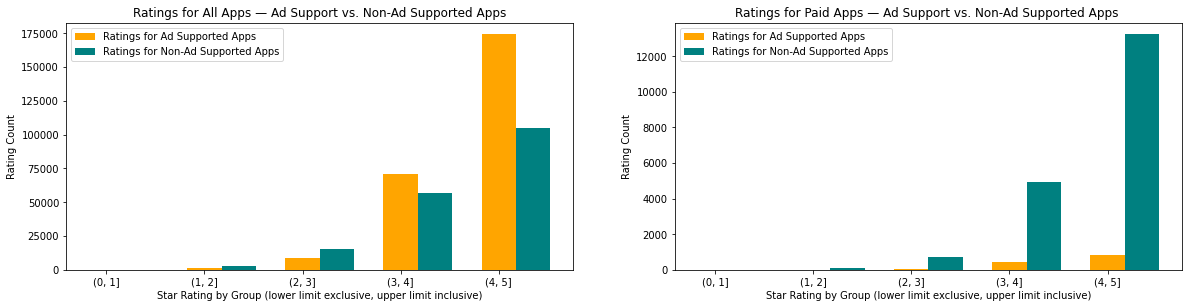

,Rating,Rating Count,Price
Ad Supported,,,
False,3.98,188,1.04
True,4.03,1557,0.02


In [ ]:
# binning the data into 5 categories to be able to better see how the ratings differ
bins = np.arange(0,6) 
rating_bins = pd.cut(playstore.Rating, bins)
playstore['Ratings_Grouped'] = rating_bins.astype(str)

# creating labels and ticks for the x axis
rating_label  = [item for item in playstore['Ratings_Grouped'].value_counts().sort_index().index] #5 labels for the x-axis
ticks = np.arange(len(rating_label)) #5 ticks for the x-axis

plt.figure(figsize=(20,10))
plt.subplot(221)

# first subplot to plot ratings vs rating count for free apps
plt.bar(ticks, playstore[playstore['Ad Supported'] == True]['Ratings_Grouped'].value_counts().sort_index(), 
        color = 'orange', label = 'Ratings for Ad Supported Apps', width=.35)
plt.bar(ticks +.35, playstore[playstore['Ad Supported'] == False]['Ratings_Grouped'].value_counts().sort_index(), 
        color = 'teal', label = 'Ratings for Non-Ad Supported Apps', width=.35)
plt.xticks(ticks,rating_label)
plt.xlabel('Star Rating by Group (lower limit exclusive, upper limit inclusive)')
plt.ylabel('Rating Count')
plt.title('Ratings for All Apps — Ad Support vs. Non-Ad Supported Apps')
plt.legend()

plt.subplot(222)

# second subplot to plot ratings vs rating count for paid apps
plt.bar(ticks, playstore[(playstore['Ad Supported'] == True) & (playstore['Free'] == False)]['Ratings_Grouped'].value_counts().sort_index(), 
        color = 'orange', label = 'Ratings for Ad Supported Apps', width=.35)
plt.bar(ticks+.35, playstore[(playstore['Ad Supported'] == False) & (playstore['Free'] == False)]['Ratings_Grouped'].value_counts().sort_index(), 
        color = 'teal', label = 'Ratings for Non-Ad Supported Apps', width=.35)
plt.xticks(ticks,rating_label)
plt.xlabel('Star Rating by Group (lower limit exclusive, upper limit inclusive)')
plt.ylabel('Rating Count')
plt.title('Ratings for Paid Apps — Ad Support vs. Non-Ad Supported Apps ')
plt.legend()
plt.show()

# mathematical computations to determine count for average rating
# Average Data for All Apps
playstore.groupby('Ad Supported').agg({'Estimated_Installs':'mean','Rating':'mean','Rating Count':'count'}).round(2)
# Average Data for Paid Apps
playstore[playstore['Free'] == False].groupby('Ad Supported').agg({'Estimated_Installs':'mean','Rating':'mean','Rating Count':'count', 'Price':'mean'}).round(2)
# Effect of ads & in-app purchases on paid apps
playstore[playstore['Free'] == False].groupby(['Ad Supported','In App Purchases']).agg({'Estimated_Installs':'mean','Rating':'mean','Rating Count':'count', 'Price':'mean'}).round(2)
# Effect of ads & editors choice on paid apps
playstore[playstore['Free'] == False].groupby(['Ad Supported','Editors Choice']).agg({'Estimated_Installs':'mean','Rating':'mean','Rating Count':'count', 'Price':'mean'}).round(2)

# analyzing effect of ads on the two popular categories discussed earlier - communication, video players & racing
playstore[(playstore['Category'] == 'Communication')].groupby(['Ad Supported']).agg({'Rating':'mean','Rating Count':'count','Price':'mean'}).round(2) #communication
playstore[(playstore['Category'] == 'Video Players & Editors')].groupby(['Ad Supported']).agg({'Rating':'mean','Rating Count':'count','Price':'mean'}).round(2) #video players & editors
playstore[(playstore['Category'] == 'Racing')].groupby(['Ad Supported']).agg({'Rating':'mean','Rating Count':'count','Price':'mean'}).round(2) #racing

# Google Play Store Reviews Dataset

## Reading in Google Play Store Reviews Corpus

In [ ]:
# reading in data and changing Dtype of date columns to proper datetime
gps_reviews = pd.read_csv('/content/drive/MyDrive/BSAN 6080 Project/Datasets/GPS_app_reviews.csv', parse_dates = ['at','repliedAt'], converters={'Event Date': lambda x: x.strftime('%Y-%m-%d %H:%M:%S')})

In [ ]:
# renaming columns
gps_reviews.rename(columns={'reviewId':'review_id',
                   'userName':'username',
                   'userImage':'userimage',
                   'content':'review_text',
                   'score':'rating',
                   'thumbsUpCount':'up_count',
                   'at':'review_date',
                   'replyContent':'reply_text',
                   'repliedAt':'reply_date',
                   'sortOrder':'sort_order',
                   'appId':'app_id'},inplace=True)

In [ ]:
# examining first two rows
gps_reviews.head(2)

,review_id,username,userimage,review_text,rating,up_count,reviewCreatedVersion,review_date,reply_text,reply_date,sort_order,app_id
0,gp:AOqpTOEhZuqSqqWnaKRgv-9ABYdajFUB0WugPGh-SG-...,Eric Tie,https://play-lh.googleusercontent.com/a-/AOh14...,I cannot open the app anymore,1,0,5.4.0.6,2020-10-27 21:24:41,NaN,NaT,newest,com.anydo
1,gp:AOqpTOH0WP4IQKBZ2LrdNmFy_YmpPCVrV3diEU9KGm3...,john alpha,https://play-lh.googleusercontent.com/a-/AOh14...,I have been begging for a refund from this app...,1,0,NaN,2020-10-27 14:03:28,"Please note that from checking our records, yo...",2020-10-27 15:05:52,newest,com.anydo


In [ ]:
# create high_low column
gps_reviews['high_low'] = np.where(gps_reviews['rating'] > 3, 1, 0)

In [ ]:
# creating a high and low dataset for every service category
gps_reviews_high = gps_reviews[gps_reviews['high_low'] == 1]
gps_reviews_low = gps_reviews[gps_reviews['high_low'] == 0]

## EDA

In [ ]:
# looking at shape
gps_reviews.shape

(12495, 13)

In [ ]:
# checking for null values
gps_reviews.isna().sum()

review_id                  0
username                   0
userimage                  0
review_text                0
rating                     0
up_count                   0
reviewCreatedVersion    2162
review_date                0
reply_text              6677
reply_date              6677
sort_order                 0
app_id                     0
high_low                   0
dtype: int64

In [ ]:
# examing index dtype and columns, non-null values
gps_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12495 entries, 0 to 12494
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   review_id             12495 non-null  object        
 1   username              12495 non-null  object        
 2   userimage             12495 non-null  object        
 3   review_text           12495 non-null  object        
 4   rating                12495 non-null  int64         
 5   up_count              12495 non-null  int64         
 6   reviewCreatedVersion  10333 non-null  object        
 7   review_date           12495 non-null  datetime64[ns]
 8   reply_text            5818 non-null   object        
 9   reply_date            5818 non-null   datetime64[ns]
 10  sort_order            12495 non-null  object        
 11  app_id                12495 non-null  object        
 12  high_low              12495 non-null  int64         
dtypes: datetime64[ns

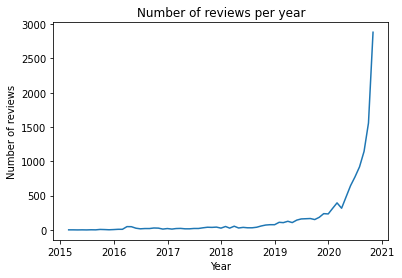

In [ ]:
gps_reviews = gps_reviews.set_index('review_date')
plt.plot(gps_reviews['review_text'].resample('M').count())
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.title('Number of reviews per year')
plt.show()

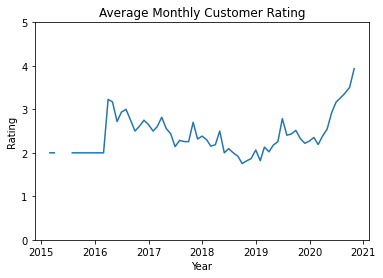

In [ ]:
plt.plot(gps_reviews['rating'].resample('M').mean())
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Average Monthly Customer Rating')
plt.ylim(0,5)
plt.show()

In [ ]:
# discover the actual counts of reviews peresent in Rating column
gps_reviews['rating'].value_counts().sort_index(ascending=False)

5    2879
4    2775
3    1991
2    2344
1    2506
Name: rating, dtype: int64

In [ ]:
gps_reviews['rating'].describe()

count    12495.000000
mean         3.094198
std          1.457693
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

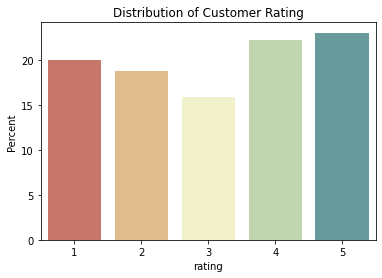

In [ ]:
# histogram of ratings
colors=['#D56C5B', '#ECBE81', '#F7F7C6', '#C0DCA9', '#60A2A3']
ax = sns.barplot(data=gps_reviews, x='rating', y='rating', palette= colors, estimator=lambda x: len(x) / len(gps_reviews) * 100)
ax.set(ylabel="Percent")
plt.title('Distribution of Customer Rating')
plt.show()

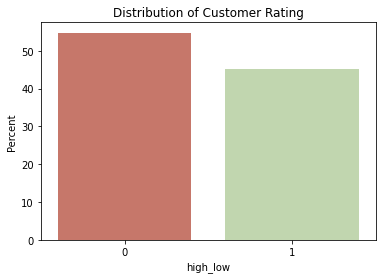

In [ ]:
# histogram of ratings
colors=['#D56C5B', '#C0DCA9']
ax = sns.barplot(data=gps_reviews, x='high_low', y='high_low', palette= colors, estimator=lambda x: len(x) / len(gps_reviews) * 100)
ax.set(ylabel="Percent")
plt.title('Distribution of Customer Rating')
plt.show()

In [ ]:
# looking at balance
gps_reviews['high_low'].value_counts()

0    6841
1    5654
Name: high_low, dtype: int64

### Word Clouds

In [ ]:
# wordnet and treebank have different tagging systems
# Create a function to define a mapping between wordnet tags and POS tags 
def get_wordnet_pos(pos_tag):

    if pos_tag.startswith('J'):
        return wordnet.ADJ 

    elif pos_tag.startswith('V'):
        return wordnet.VERB 

    elif pos_tag.startswith('N'):
        return wordnet.NOUN

    elif pos_tag.startswith('R'):
        return wordnet.ADV
    
    else:
        return wordnet.NOUN # default, return wordnet tag "NOUN"

#Create a function to lemmatize tokens in the reviews
def lemmatized_tokens(text):
        text = text.lower()
        pattern = r'\b[a-zA-Z]{3,}\b'                 
        tokens = nltk.regexp_tokenize(text, pattern) # tokenize the text
        tagged_tokens = nltk.pos_tag(tokens)  # a list of tuples (word, pos_tag)
          
        stop_words = stopwords.words('english')
        new_stopwords = ["hotel","everything","anything","nothing","thing","need",
                        "good","great","excellent","perfect","much","even","really"]  #customize extra stop_words
        stop_words.extend(new_stopwords)
        stop_words = set(stop_words)
        
        wordnet_lemmatizer = WordNetLemmatizer()
        # get lemmatized tokens                             #call function "get_wordnet_pos"
        lemmatized_words=[wordnet_lemmatizer.lemmatize(word, get_wordnet_pos(tag)) 
                  # tagged_tokens is a list of tuples (word, tag)
                  for (word, tag) in tagged_tokens \
                  # remove stop words
                  if word not in stop_words and \
                  # remove punctuations
                  word not in string.punctuation]

        return lemmatized_words

In [ ]:
#Create a function to generate wordcloud
def wordcloud(review_df, review_colname, color, title):
    '''    
    INPUTS:
        reivew_df - dataframe, positive or negative reviews
        review_colname - column name, positive or negative review
        color - background color of worldcloud
        title - title of the wordcloud
    OUTPUT:
    Wordcloud visuazliation
    '''  
    text = review_df[review_colname].tolist()
    text_str = ' '.join(lemmatized_tokens(' '.join(text))) #call function "lemmatized_tokens"
    wordcloud = WordCloud(collocations = False,
                          background_color = color,
                          width=1600, 
                          height=800, 
                          margin=2,
                          min_font_size=20).generate(text_str)

    plt.figure(figsize = (15, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.figtext(.5,.8,title,fontsize = 20, ha='center')
    plt.show()

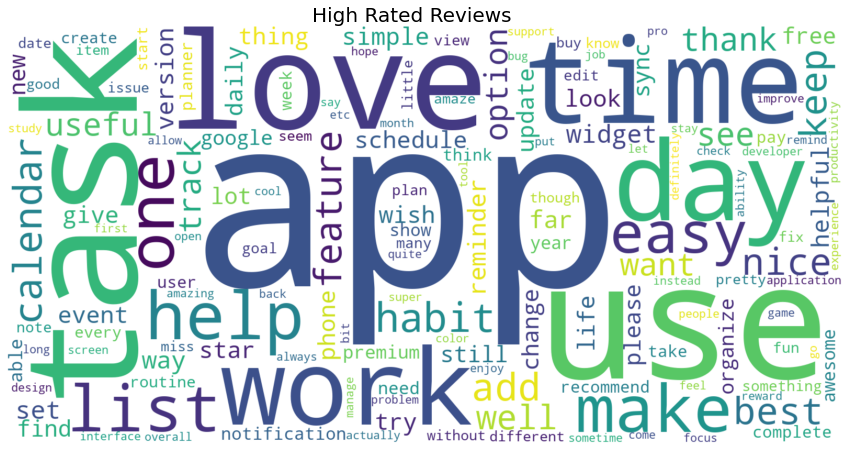

In [ ]:
# word cloud for Positive Reviews
wordcloud(gps_reviews_high,'review_text', 'white','High Rated Reviews')

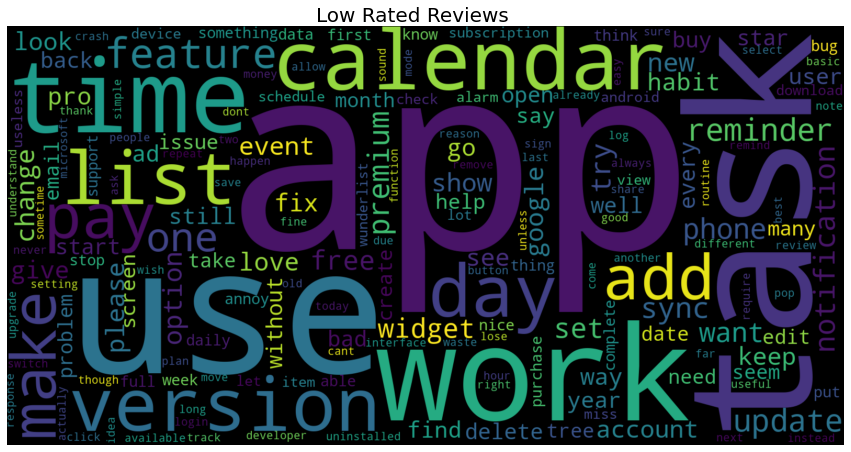

In [ ]:
# word cloud for Negative Reviews
wordcloud(gps_reviews_low,'review_text', 'black', 'Low Rated Reviews')

# Google Play Store - Food Delivery App Reviews Dataset

## Reading in Food Delivery App Reviews Corpus

In [ ]:
# reading in data and changing Dtype of date columns to proper datetime
food_reviews = pd.read_csv('/content/drive/MyDrive/BSAN 6080 Project/Datasets/food_delivery_reviews.csv', parse_dates = ['review_date','reply_date'], converters={'Event Date': lambda x: x.strftime('%Y-%m-%d %H:%M:%S')})

In [ ]:
food_reviews.head(2)

,review_id,username,userimage,review_text,rating,up_count,review_created_version,review_date,reply_text,reply_date,sort_order,app_id
0,gp:AOqpTOGxOYaUEWvTwho1jhtghoMa_iMjYxBYBDhRu4V...,Christine Hudson,https://play-lh.googleusercontent.com/a/AATXAJ...,I typically consider DoorDash the best of the ...,1,208,15.41.8,2022-03-12 22:53:54,NaN,NaT,most_relevant,com.dd.doordash
1,gp:AOqpTOEIzhtGnqoC8bsE90iT6k-bHMyrXwy4yyLwUjB...,Alan Donaldson,https://play-lh.googleusercontent.com/a-/AOh14...,It could just be bad luck but on my first larg...,1,21,15.42.20,2022-03-21 13:50:02,NaN,NaT,most_relevant,com.dd.doordash


## EDA

In [ ]:
# examining shape
food_reviews.shape

(13474, 12)

In [ ]:
# checking for null values
food_reviews.isna().sum()

review_id                     0
username                      0
userimage                     0
review_text                   0
rating                        0
up_count                      0
review_created_version     1128
review_date                   0
reply_text                10118
reply_date                10118
sort_order                    0
app_id                        0
dtype: int64

In [ ]:
# examing index dtype and columns, non-null values
food_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13474 entries, 0 to 13473
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   review_id               13474 non-null  object        
 1   username                13474 non-null  object        
 2   userimage               13474 non-null  object        
 3   review_text             13474 non-null  object        
 4   rating                  13474 non-null  int64         
 5   up_count                13474 non-null  int64         
 6   review_created_version  12346 non-null  object        
 7   review_date             13474 non-null  datetime64[ns]
 8   reply_text              3356 non-null   object        
 9   reply_date              3356 non-null   datetime64[ns]
 10  sort_order              13474 non-null  object        
 11  app_id                  13474 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(8)
memo

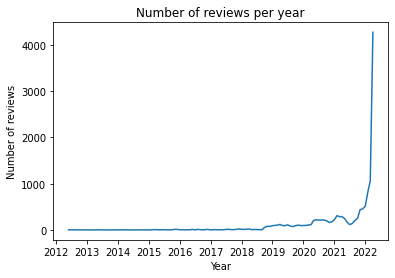

In [ ]:
food_reviews = food_reviews.set_index('review_date')
plt.plot(food_reviews['review_text'].resample('M').count())
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.title('Number of reviews per year')
plt.show()

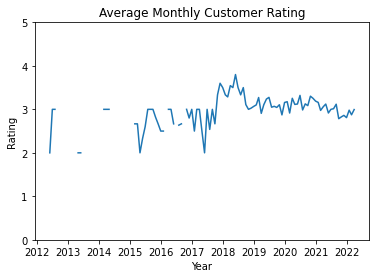

In [ ]:
plt.plot(food_reviews['rating'].resample('M').mean())
plt.xlabel('Year')
plt.ylabel('Rating')
plt.title('Average Monthly Customer Rating')
plt.ylim(0,5)
plt.show()

In [ ]:
# discover the actual counts of reviews peresent in Rating column
food_reviews['rating'].value_counts().sort_index(ascending=False)

5    2400
4    2318
3    4142
2    2214
1    2400
Name: rating, dtype: int64

In [ ]:
food_reviews['rating'].describe()

count    13474.000000
mean         3.007719
std          1.327173
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

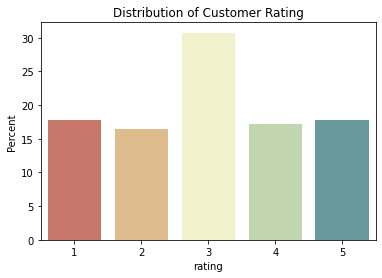

In [ ]:
# histogram of ratings
colors=['#D56C5B', '#ECBE81', '#F7F7C6', '#C0DCA9', '#60A2A3']
ax = sns.barplot(data=food_reviews, x='rating', y='rating', palette= colors, estimator=lambda x: len(x) / len(food_reviews) * 100)
ax.set(ylabel="Percent")
plt.title('Distribution of Customer Rating')
plt.show()

In [ ]:
# create high_low column
# lots of 3 values... what to do with this?
food_reviews['high_low'] = np.where(food_reviews['rating'] > 3, 1, 0)

In [ ]:
# looking at balance
food_reviews['high_low'].value_counts()

0    8756
1    4718
Name: high_low, dtype: int64

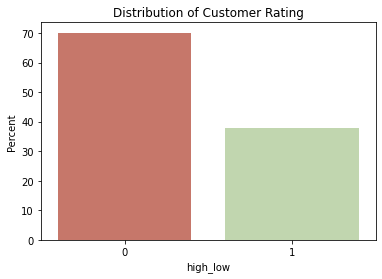

In [ ]:
# histogram of ratings
colors=['#D56C5B', '#C0DCA9']
ax = sns.barplot(data=food_reviews, x='high_low', y='high_low', palette= colors, estimator=lambda x: len(x) / len(gps_reviews) * 100)
ax.set(ylabel="Percent")
plt.title('Distribution of Customer Rating')
plt.show()